<a href="https://colab.research.google.com/github/Cinthia110/Estimacion-EMG-MVC-LSTM/blob/main/Proyecto_MVC_Rregresion_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#Intalar wfdb
!pip install wfdb==4.0.0 --no-deps

In [6]:
#Importar librerías
import wfdb
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch
import os
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive

In [7]:
#Montar Drive (si no lo tienes montado)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Definir carpeta
folder_path = '/content/drive/MyDrive/Data_Base/'

In [67]:
import glob
import os
import wfdb
import numpy as np
import pandas as pd
from scipy.signal import welch

# --- Ruta de la carpeta ---
folder_path = '/content/drive/MyDrive/Data_Base/'

# Buscar TODOS los .hea
hea_files = glob.glob(folder_path + '*.hea')
print(f' Se encontraron {len(hea_files)} señales.')

# --- Parámetros ---
win_ms = 200  # ventana de 200 ms
overlap = 0.5

# --- Lista para guardar características ---
all_features = []

# --- Loop por cada archivo ---
for hea_file in hea_files:
    try:
        emg_name = os.path.splitext(hea_file)[0]

        # --- Cargar señal ---
        emg_record = wfdb.rdrecord(emg_name)
        emg_data = emg_record.p_signal
        fs_emg = emg_record.fs

        print(f'\n Cargando: {os.path.basename(emg_name)} - shape: {emg_data.shape}, fs={fs_emg} Hz')

        # Mejor canal
        rms_channels = np.sqrt(np.mean(emg_data**2, axis=0))
        best_channel = np.argmax(rms_channels)
        emg_ch = emg_data[:, best_channel]

        # Ventaneo
        win_size = int(fs_emg * (win_ms / 1000))
        step_size = int(win_size * (1 - overlap))

        rms_list = []
        avr_list = []
        mnf_list = []

        for start in range(0, len(emg_ch) - win_size, step_size):
            window = emg_ch[start:start + win_size]

            rms = np.sqrt(np.mean(window**2))
            avr = np.mean(np.abs(window))
            f, Pxx = welch(window, fs_emg, nperseg=win_size)
            mnf = np.sum(f * Pxx) / np.sum(Pxx)

            rms_list.append(rms)
            avr_list.append(avr)
            mnf_list.append(mnf)

        # %MVC
        rms_arr = np.array(rms_list)
        avr_arr = np.array(avr_list)
        mnf_arr = np.array(mnf_list)

        mvc_rms = np.max(rms_arr)
        rms_percent = (rms_arr / mvc_rms) * 100

        # Guardar cada ventana
        count_windows = 0
        for j in range(len(rms_percent)):
            mvc_value = rms_percent[j]

            if mvc_value < 10:
                continue  # omitir ventanas muy bajas

            feature = {
                'signal_name': os.path.basename(emg_name),
                'best_channel': best_channel,
                'rms_percent': rms_percent[j],
                'avr': avr_arr[j],
                'mnf': mnf_arr[j]
            }

            all_features.append(feature)
            count_windows += 1

        print(f' → Ventanas generadas: {count_windows}')

    except Exception as e:
        print(f' Error en archivo {hea_file}: {e}')


# Guardar CSV
df_features = pd.DataFrame(all_features)
output_csv = folder_path + 'EMG_features_RMS_ARV_MNF.csv'
df_features.to_csv(output_csv, index=False)
print(f'\n CSV generado con {len(df_features)} ventanas totales')
print(f' Guardado en: {output_csv}')


 Se encontraron 60 señales.

 Cargando: U1S1_mvc_preprocess_finger1_extension - shape: (20480, 256), fs=2048 Hz
 → Ventanas generadas: 99

 Cargando: U1S1_mvc_preprocess_finger1_flexion - shape: (20480, 256), fs=2048 Hz
 → Ventanas generadas: 99

 Cargando: U1S1_mvc_preprocess_finger2_extension - shape: (20480, 256), fs=2048 Hz
 → Ventanas generadas: 99

 Cargando: U1S1_mvc_preprocess_finger2_flexion - shape: (20480, 256), fs=2048 Hz
 → Ventanas generadas: 99

 Cargando: U1S1_mvc_preprocess_finger3_extension - shape: (20480, 256), fs=2048 Hz
 → Ventanas generadas: 99

 Cargando: U1S1_mvc_preprocess_finger3_flexion - shape: (20480, 256), fs=2048 Hz
 → Ventanas generadas: 99

 Cargando: U1S1_mvc_preprocess_finger4_extension - shape: (20480, 256), fs=2048 Hz
 → Ventanas generadas: 99

 Cargando: U1S1_mvc_preprocess_finger4_flexion - shape: (20480, 256), fs=2048 Hz
 → Ventanas generadas: 99

 Cargando: U1S1_mvc_preprocess_finger5_flexion - shape: (20480, 256), fs=2048 Hz
 → Ventanas genera

In [68]:
# --- Cargar CSV ---
# Cargar CSV
df = pd.read_csv('/content/drive/MyDrive/Data_Base/EMG_features_RMS_ARV_MNF.csv')
print(f'Datos cargados: {df.shape[0]} muestras')

# Preparación
feature_cols = ['rms_percent', 'avr', 'mnf']
grouped = df.groupby('signal_name')

timesteps = 10
X_seq = []
y_seq_reg = []


# Construir secuencias
for signal_name, group in grouped:
    group_sorted = group.sort_index()
    features = group_sorted[feature_cols].values
    labels_reg = group_sorted['rms_percent'].values

    for i in range(len(features) - timesteps):
        X_seq.append(features[i:i+timesteps])
        y_seq_reg.append(labels_reg[i+timesteps-1])

X_seq = np.array(X_seq)
y_seq_reg = np.array(y_seq_reg)

print(f'Secuencias generadas: {X_seq.shape[0]}')
print(f'Forma de X: {X_seq.shape}')

# Escalar X
scaler = StandardScaler()
X_seq_reshaped = X_seq.reshape(-1, X_seq.shape[2])
X_seq_scaled = scaler.fit_transform(X_seq_reshaped)
X_seq_scaled = X_seq_scaled.reshape(-1, timesteps, X_seq.shape[2])
joblib.dump(scaler, '/content/drive/MyDrive/Data_Base/scaler_lstm_emg.pkl')
print(' Scaler X guardado')

# Split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_seq_scaled, y_seq_reg, test_size=0.2, random_state=42)

# Normalizar Y (Regresión)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_reg_scaled = scaler_y.fit_transform(y_train_reg.reshape(-1,1))
y_test_reg_scaled = scaler_y.transform(y_test_reg.reshape(-1,1))
joblib.dump(scaler_y, '/content/drive/MyDrive/Data_Base/scaler_y_reg.pkl')
print(' Scaler Y guardado')


Datos cargados: 5480 muestras
Secuencias generadas: 4880
Forma de X: (4880, 10, 3)
 Scaler X guardado
 Scaler Y guardado


In [70]:
# Modelo LSTM Regressor
model_reg = Sequential()
model_reg.add(LSTM(128, input_shape=(timesteps, X_seq.shape[2]), return_sequences=True))
model_reg.add(Dropout(0.3))
model_reg.add(LSTM(64, return_sequences=False))
model_reg.add(Dense(32, activation='relu'))
model_reg.add(Dense(1, activation='linear'))

model_reg.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_reg.summary()
# Entrenamiento
history_reg = model_reg.fit(
    X_train_reg, y_train_reg_scaled, epochs=50, batch_size=32, validation_split=0.2
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 10, 128)        │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,105 (465.25 KB)

 Trainable params: 119,105 (465.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - loss: 0.1414 - mae: 0.2776 - val_loss: 0.0055 - val_mae: 0.0507
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0060 - mae: 0.0536 - val_loss: 0.0033 - val_mae: 0.0390
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0042 - mae: 0.0464 - val_loss: 0.0021 - val_mae: 0.0301
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0031 - mae: 0.0410 - val_loss: 0.0020 - val_mae: 0.0345
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0022 - mae: 0.0355 - val_loss: 7.0654e-04 - val_mae: 0.0185
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0015 - mae: 0.0297 - val_loss: 5.3332e-04 - val_mae: 0.0172
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0010 - mae: 0.0246 - val_loss: 5.4697e-04 - val_mae: 0.0183
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 9.2389e-04 - mae: 0.0232 - val_loss: 4.7654e-04 - val_mae: 0.0174
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 25

In [71]:
# Guardar modelo
model_reg.save('/content/drive/MyDrive/Data_Base/modelo_lstm_emg_reg.keras')
print('Modelo regresor guardado')

Modelo regresor guardado


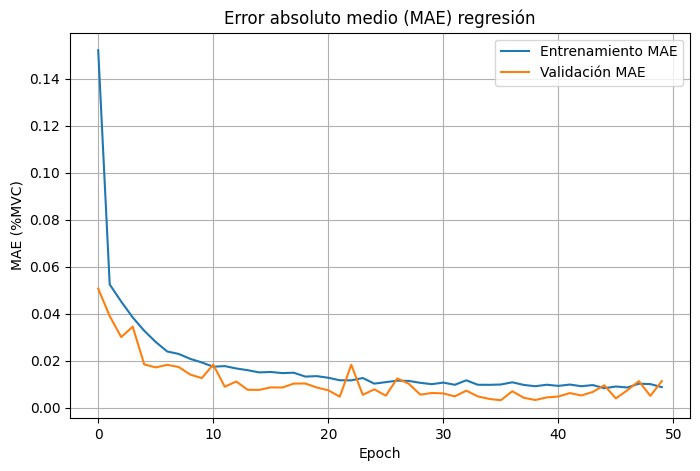

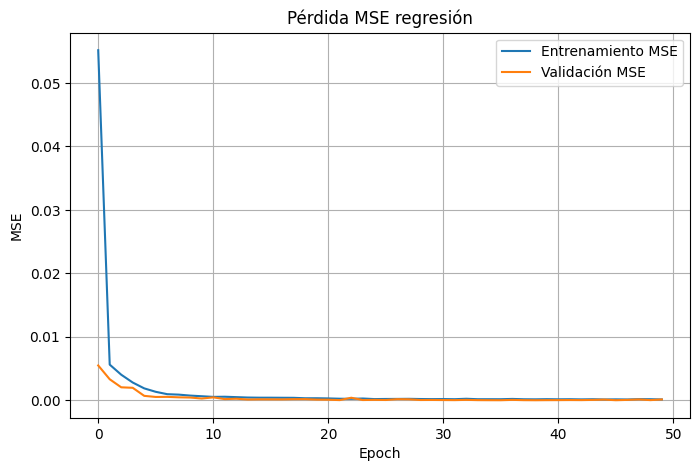

In [72]:
# Gráficas
plt.figure(figsize=(8,5))
plt.plot(history_reg.history['mae'], label='Entrenamiento MAE')
plt.plot(history_reg.history['val_mae'], label='Validación MAE')
plt.title('Error absoluto medio (MAE) regresión')
plt.xlabel('Epoch')
plt.ylabel('MAE (%MVC)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history_reg.history['loss'], label='Entrenamiento MSE')
plt.plot(history_reg.history['val_loss'], label='Validación MSE')
plt.title('Pérdida MSE regresión')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
# Guardar modelos
model_class.save('/content/drive/MyDrive/Data_Base/modelo_lstm_emg_class.h5')
print('Clasificador guardado')

model_reg.save('/content/drive/MyDrive/Data_Base/modelo_lstm_emg_reg.keras')
print('Regressor guardado')


Clasificador guardado
Regressor guardado


In [89]:
# --- Librerías ---
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import joblib
from tensorflow.keras.models import load_model
import glob
import os
import pandas as pd

# --- Parámetros generales ---
folder_validacion = '/content/drive/MyDrive/Data_Base/EMG_NUEVAS/'
folder_resultados = folder_validacion + 'Resultados/'

timesteps = 10
win_ms = 200
overlap = 0.5

# --- Cargar scaler y modelo ---
scaler = joblib.load('/content/drive/MyDrive/Data_Base/scaler_lstm_emg.pkl')
model_reg = load_model('/content/drive/MyDrive/Data_Base/modelo_lstm_emg_reg.keras')

# --- Crear carpeta de resultados si no existe ---
os.makedirs(folder_resultados, exist_ok=True)

# --- FUNCION para una señal individual ---
def predecir_senal_nueva(archivo_dat, save_csv=True, save_plot=True):

    emg_name = folder_validacion + archivo_dat.replace('.dat','')
    emg_record = wfdb.rdrecord(emg_name)
    emg_data = emg_record.p_signal
    fs_emg = emg_record.fs

    print(f' Señal cargada: {archivo_dat} - shape: {emg_data.shape}, fs={fs_emg} Hz')

    # Mejor canal
    rms_channels = np.sqrt(np.mean(emg_data**2, axis=0))
    best_channel = np.argmax(rms_channels)
    print(f'→ Mejor canal EMG: {best_channel}')

    emg_ch = emg_data[:, best_channel]

    # Ventaneo
    win_size = int(fs_emg * (win_ms / 1000))
    step_size = int(win_size * (1 - overlap))

    rms_list = []
    arv_list = []
    mnf_list = []

    for start in range(0, len(emg_ch) - win_size, step_size):
        window = emg_ch[start:start + win_size]
        rms = np.sqrt(np.mean(window**2))
        arv = np.mean(np.abs(window))
        f, Pxx = welch(window, fs_emg, nperseg=win_size)
        mnf = np.sum(f * Pxx) / np.sum(Pxx)

        rms_list.append(rms)
        arv_list.append(arv)
        mnf_list.append(mnf)

    # Arrays
    rms_arr = np.array(rms_list)
    arv_arr = np.array(arv_list)
    mnf_arr = np.array(mnf_list)

    mvc_rms = np.max(rms_arr)
    rms_percent = (rms_arr / mvc_rms) * 100

    features_arr = np.vstack([rms_percent, arv_arr, mnf_arr]).T

    # Secuencias
    X_new_seq = []
    for i in range(len(features_arr) - timesteps):
        X_new_seq.append(features_arr[i:i+timesteps])

    X_new_seq = np.array(X_new_seq)
    print(f'→ Secuencias generadas: {X_new_seq.shape}')

    # Escalar
    X_new_seq_reshaped = X_new_seq.reshape(-1, X_new_seq.shape[2])
    X_new_seq_scaled = scaler.transform(X_new_seq_reshaped)
    X_new_seq_scaled = X_new_seq_scaled.reshape(-1, timesteps, X_new_seq.shape[2])

    # Predicción
    preds_reg = model_reg.predict(X_new_seq_scaled).flatten()

    # Convertir a %MVC reales
    preds_percent = preds_reg * 100

    # Guardar CSV
    if save_csv:
        df_pred = pd.DataFrame({
            'secuencia': np.arange(len(preds_percent)),
            'predicted_mvc_percent': preds_percent,
            'signal_name': archivo_dat
        })
        csv_name = folder_resultados + f'prediccion_{archivo_dat.replace(".dat",".csv")}'
        df_pred.to_csv(csv_name, index=False)
        print(f' CSV guardado: {csv_name}')

    # Guardar Plot
    if save_plot:
        plt.figure(figsize=(12,5))
        plt.plot(preds_percent, label='Predicción %MVC', color='b')
        plt.ylim(0,100)
        plt.title(f'Predicción continua %MVC - {archivo_dat}')
        plt.xlabel('Secuencia')
        plt.ylabel('% MVC')
        plt.legend()
        plt.grid(True)
        fig_name = folder_resultados + f'fig_{archivo_dat.replace(".dat",".png")}'
        plt.savefig(fig_name)
        plt.close()
        print(f' Imagen guardada: {fig_name}')

    return preds_percent  # Para usarlo después

# --- FUNCION para toda la carpeta ---
def predecir_carpeta_validacion(save_csv=True, save_plot=True):

    lista_dat = sorted(glob.glob(folder_validacion + '*.dat'))
    print(f'\n Se encontraron {len(lista_dat)} señales en la carpeta.')

    for archivo_path in lista_dat:
        archivo_dat = os.path.basename(archivo_path)
        print(f'\n--- Procesando: {archivo_dat} ---')
        predecir_senal_nueva(archivo_dat, save_csv=save_csv, save_plot=save_plot)

    print('\n Proceso terminado.')


In [90]:
predecir_carpeta_validacion(save_csv=True, save_plot=True)



 Se encontraron 6 señales en la carpeta.

--- Procesando: mvc_preprocess_finger1_extension.dat ---
 Señal cargada: mvc_preprocess_finger1_extension.dat - shape: (20480, 256), fs=2048 Hz
→ Mejor canal EMG: 135
→ Secuencias generadas: (89, 10, 3)
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step
 CSV guardado: /content/drive/MyDrive/Data_Base/EMG_NUEVAS/Resultados/prediccion_mvc_preprocess_finger1_extension.csv
 Imagen guardada: /content/drive/MyDrive/Data_Base/EMG_NUEVAS/Resultados/fig_mvc_preprocess_finger1_extension.png

--- Procesando: mvc_preprocess_finger1_flexion.dat ---
 Señal cargada: mvc_preprocess_finger1_flexion.dat - shape: (20480, 256), fs=2048 Hz
→ Mejor canal EMG: 143
→ Secuencias generadas: (89, 10, 3)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
 CSV guardado: /content/drive/MyDrive/Data_Base/EMG_NUEVAS/Resultados/prediccion_mvc_preprocess_finger1_flexion.csv
 Imagen guardada: /content/drive/MyDrive/Data_Base/EMG_NUEVAS/Resultados/fig_mvc_preprocess_finger1_flexion.png

--- Procesando: 

In [91]:
def graficar_senales_originales():

    lista_dat = sorted(glob.glob(folder_validacion + '*.dat'))
    print(f'\n Se encontraron {len(lista_dat)} señales en la carpeta.')

    for archivo_path in lista_dat:
        archivo_dat = os.path.basename(archivo_path)
        print(f'\n--- Procesando: {archivo_dat} ---')

        # Cargar señal
        emg_name = folder_validacion + archivo_dat.replace('.dat','')
        emg_record = wfdb.rdrecord(emg_name)
        emg_data = emg_record.p_signal
        fs_emg = emg_record.fs

        # Mejor canal
        rms_channels = np.sqrt(np.mean(emg_data**2, axis=0))
        best_channel = np.argmax(rms_channels)
        print(f'→ Mejor canal EMG: {best_channel}')

        emg_ch = emg_data[:, best_channel]

        # Eje tiempo en segundos
        tiempo = np.arange(len(emg_ch)) / fs_emg

        # Graficar
        plt.figure(figsize=(12,5))
        plt.plot(tiempo, emg_ch, color='b')
        plt.title(f'Señal original EMG - {archivo_dat} (canal {best_channel})')
        plt.xlabel('Tiempo [s]')
        plt.ylabel('Amplitud (original)')
        plt.grid(True)

        # Guardar
        fig_name = folder_resultados + f'fig_original_{archivo_dat.replace(".dat",".png")}'
        plt.savefig(fig_name)
        plt.close()
        print(f' Imagen guardada: {fig_name}')
    print('\n Proceso terminado: señales originales graficadas.')

In [92]:
graficar_senales_originales()



 Se encontraron 6 señales en la carpeta.

--- Procesando: mvc_preprocess_finger1_extension.dat ---
→ Mejor canal EMG: 135
 Imagen guardada: /content/drive/MyDrive/Data_Base/EMG_NUEVAS/Resultados/fig_original_mvc_preprocess_finger1_extension.png

--- Procesando: mvc_preprocess_finger1_flexion.dat ---
→ Mejor canal EMG: 143
 Imagen guardada: /content/drive/MyDrive/Data_Base/EMG_NUEVAS/Resultados/fig_original_mvc_preprocess_finger1_flexion.png

--- Procesando: mvc_preprocess_finger2_extension.dat ---
→ Mejor canal EMG: 64
 Imagen guardada: /content/drive/MyDrive/Data_Base/EMG_NUEVAS/Resultados/fig_original_mvc_preprocess_finger2_extension.png

--- Procesando: mvc_preprocess_finger3_extension.dat ---
→ Mejor canal EMG: 84
 Imagen guardada: /content/drive/MyDrive/Data_Base/EMG_NUEVAS/Resultados/fig_original_mvc_preprocess_finger3_extension.png

--- Procesando: mvc_preprocess_finger4_extension.dat ---
→ Mejor canal EMG: 13
 Imagen guardada: /content/drive/MyDrive/Data_Base/EMG_NUEVAS/Result

In [88]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predicción en el set de prueba
y_pred_test_scaled = model_reg.predict(X_test_reg)

# Reescalar las predicciones a %MVC original
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_reg_original = scaler_y.inverse_transform(y_test_reg_scaled)

# Calcular métricas
mae = mean_absolute_error(y_test_reg_original, y_pred_test)
mse = mean_squared_error(y_test_reg_original, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg_original, y_pred_test)

# Mostrar resultados
print(f"MAE: {mae:.4f} %MVC")
print(f"RMSE: {rmse:.4f} %MVC")
print(f"R² (Coeficiente de determinación): {r2:.4f}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
MAE: 1.0428 %MVC
RMSE: 1.0857 %MVC
R² (Coeficiente de determinación): 0.9967
